In [1]:
include("QuantumToolbox/QuantumWrapper.jl")


Main.QuantumWrapper

In [2]:
using .QuantumWrapper


In [65]:
using LinearAlgebra
using SparseArrays
using Base.Threads
using WignerSymbols
N = AM_Toolbox.angularMomentum("N", [1])


function compute_SHC!(operator, q, basis; order = 2)
    for (j, state) in enumerate(basis), (k, state2) in enumerate(basis)
        if true #abs(state[2] - state2[2]) <= order && -1*state[1] + state2[1] + q == 0
            mNp, Np = state2 
            mN, N1 = state

            operator[j, k] = (-1)^(mN) * sqrt((2*N1 + 1)*(2*Np + 1)) * wigner3j(N1, order, Np, -mN, q, mNp) * wigner3j(N1, order, Np, 0, 0, 0)
        end
    end
end



function T2_A(N)

    T2C = [spzeros(ComplexF64, length(N.spin), length(N.spin)) for _ in -2:2] 
    @threads for i in 1:5
        q = i - 3
        compute_SHC!(T2C[i], q, AM_Toolbox.getBasis(N.spin), order = 2)
    end
    T2C
end
function makeT2(I1, I2)
    T2m2 = 0.5 * (I1[1] * I2[1] - 1im*I1[1] * I2[2] - 1im*I1[2] * I2[1] - I1[2] * I2[2])
    T2p2 = 0.5 * (I1[1] * I2[1] + 1im*I1[1] * I2[2] + 1im*I1[2] * I2[1] - I1[2] * I2[2])

    T2m1 = 0.5 * (I1[1] * I2[3] - 1im*I1[2] * I2[3] + I1[3] * I2[1] - 1im*I1[3] * I2[2])
    T2p1 = -0.5 * (I1[1] * I2[3] + 1im*I1[2] * I2[3] + I1[3] * I2[1] + 1im*I1[3] * I2[2])

    T20 = -sqrt(1/6) * (I1[1] * I2[1] + I1[2] * I2[2]) + sqrt(2/3) * I1[3] * I2[3]

    T = [T2m2, T2m1, T20, T2p1, T2p2]

    return T
end

function tensor_dot(T1, T2; order = 2)
    Tprod = spzeros(ComplexF64, size(T1[1])...)
    for (i, q) in enumerate(-order:order)
        Tprod += ((-1)^q)*T1[i]*T2[i]
    end
    Tprod
end

function polarizibility(M, pol)

    
    pol = normalize(pol)
    
    A2 = sqrt(3/2)*T2_A(M)
    dims = size(A2[1], 1)
    
    P2 = [scaler*sparse(1.0I, dims, dims) for scaler in makeT2(pol, conj.(pol))]
    
    ans = 10/15*tensor_dot(A2, P2, order = 2)
    
end

ellipticity(φ) = [ cos(φ), 1im*sin(φ),0]
angle = -pi/2:0.05:pi/2
m0, p1, m1 = [], [], []

for ang in angle
    val, vecs = eigen(Matrix(polarizibility(N, ellipticity(ang))))
    push!(m0, val[1])
    push!(m1, val[2])
    push!(p1, val[3])
end

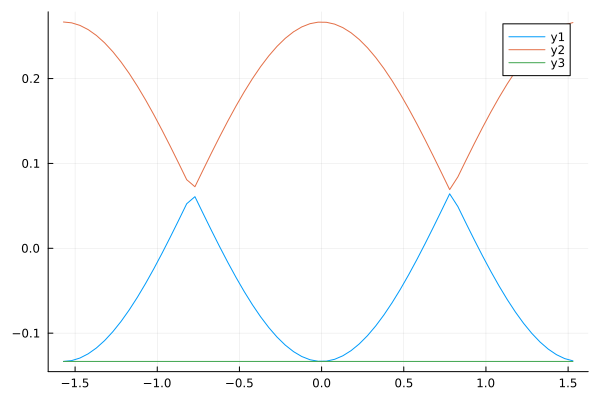

In [66]:
using Plots
plot(angle, m1)
plot!(angle, p1)
plot!(angle, m0)